In [3]:
from google.colab import files
uploaded = files.upload()

Saving data.csv to data.csv


In [5]:
# Breast Cancer Issue Priority Prediction with Fairness Improvements

### 📦 Step 1: Load and Preprocess Dataset


import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_csv("data.csv")

# Drop irrelevant or empty columns
df.drop(columns=['id', 'Unnamed: 32'], errors='ignore', inplace=True)
df.dropna(inplace=True)

# Encode diagnosis label (B = 0, M = 1)
df['diagnosis'] = LabelEncoder().fit_transform(df['diagnosis'])

In [6]:
### 🧪 Step 2: Simulate Group Labels for Fairness Testing


# Simulate a demographic group 'team' to reflect real-world team assignments or departments
# Team A (majority) - 70%, Team B (minority) - 30%
df['team'] = np.random.choice(['Team A', 'Team B'], size=len(df), p=[0.7, 0.3])


In [7]:
### 🎯 Step 3: Define Synthetic Priority Target


# Create a synthetic 'priority' label based on 'radius_mean'
# This simulates a resource allocation scenario

def map_priority(x):
    if x > 20:
        return 2  # High Priority
    elif x > 14:
        return 1  # Medium Priority
    else:
        return 0  # Low Priority

df['priority'] = df['radius_mean'].apply(map_priority)


In [8]:
### 🔄 Step 4: Prepare Features and Train-Test Split


# Define features and target
X = df.drop(columns=['priority'])
y = df['priority']

# Train-test split with stratification to preserve class distribution
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)



In [9]:
### ⚖️ Step 5: Apply SMOTE to Handle Class Imbalance


from imblearn.over_sampling import SMOTE

# SMOTE balances the minority classes in 'priority' by generating synthetic samples
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train.drop(columns=['team']), y_train)

# Reassign 'team' for group fairness analysis
X_train_res['team'] = np.random.choice(['Team A', 'Team B'], size=len(X_train_res), p=[0.7, 0.3])
X_test = X_test.copy()


In [10]:
### 🤖 Step 6: Train Random Forest Classifier


from sklearn.ensemble import RandomForestClassifier

# Random Forest is a robust ensemble model effective for tabular classification
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_res.drop(columns=['team']), y_train_res)


RandomForestClassifier(random_state=42)


--- Overall Performance ---
Accuracy: 1.0
F1 Score: 1.0
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        68
           1       1.00      1.00      1.00        37
           2       1.00      1.00      1.00         9

    accuracy                           1.00       114
   macro avg       1.00      1.00      1.00       114
weighted avg       1.00      1.00      1.00       114



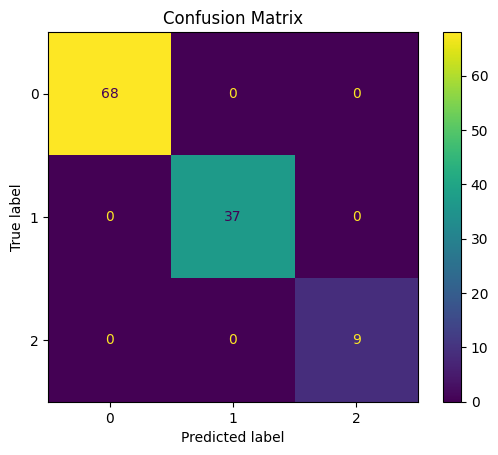

In [16]:
### 📈 Step 7: Predict and Evaluate Model Performance


from sklearn.metrics import accuracy_score, f1_score, classification_report, ConfusionMatrixDisplay

# Predict using test data
y_pred = clf.predict(X_test.drop(columns=['team']))

# Overall evaluation
print("\n--- Overall Performance ---")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("Confusion Matrix")
plt.savefig("confusion_matrix.png")
plt.show()

In [17]:
from google.colab import files
files.download("confusion_matrix.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [13]:
### 👥 Step 8: Evaluate Group-wise Fairness Metrics


# Check performance across Team A and Team B
print("\n--- Group-wise Performance ---")
for team in X_test['team'].unique():
    mask = X_test['team'] == team
    print(f"\nPerformance for {team}:")
    print(classification_report(y_test[mask], y_pred[mask]))



--- Group-wise Performance ---

Performance for Team B:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        24
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         3

    accuracy                           1.00        35
   macro avg       1.00      1.00      1.00        35
weighted avg       1.00      1.00      1.00        35


Performance for Team A:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        44
           1       1.00      1.00      1.00        29
           2       1.00      1.00      1.00         6

    accuracy                           1.00        79
   macro avg       1.00      1.00      1.00        79
weighted avg       1.00      1.00      1.00        79



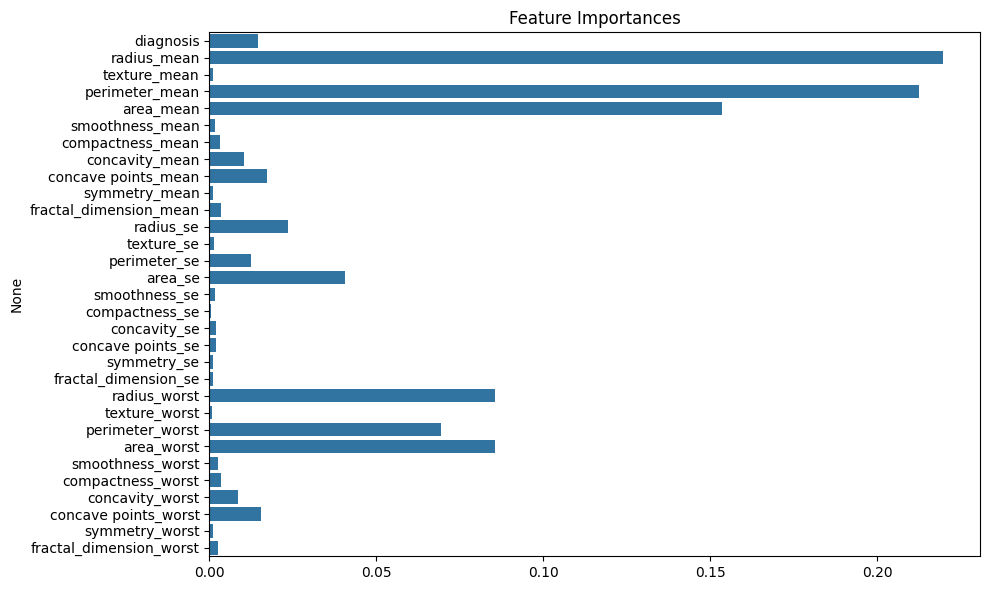

In [14]:
### 📊 Step 9: Visualize Feature Importances


# Feature importance helps detect potential proxy variables driving unfair predictions
importances = clf.feature_importances_
features = X_train_res.drop(columns=['team']).columns
plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=features)
plt.title("Feature Importances")
plt.tight_layout()
plt.savefig("feature_importance.png")
plt.show()


In [15]:
from google.colab import files
files.download("feature_importance.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>